In [1]:
from warnings import filterwarnings
filterwarnings('ignore')
import os, time
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('SP500_Sheet.csv', 
                 index_col=[0],
                 parse_dates=True)
df.tail()

,Close
Date,
2019-11-14,3096.629883
2019-11-15,3120.459961
2019-11-18,3122.030029
2019-11-19,3120.179932
2019-11-20,3108.459961


In [3]:
df.describe()

,Close
count,4779.000000
mean,1572.439778
std,588.321103
min,676.530029
25%,1142.210022
50%,1337.380005
75%,2001.664978
max,3122.030029


In [4]:
df.isna().sum()

Close    0
dtype: int64

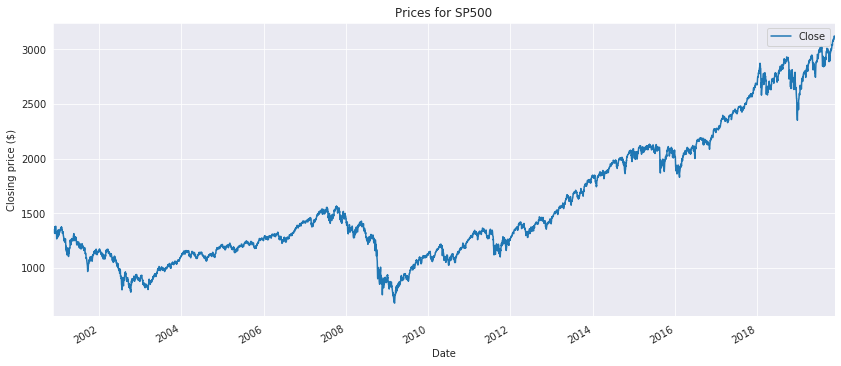

In [5]:
df.plot(figsize=(14, 6))
plt.title('Prices for SP500')
plt.ylabel('Closing price ($)')
plt.legend(loc='best')
plt.show()

In [6]:
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import load_model

lstm_models_folder = 'LSTM_models/'
if not os.path.exists(lstm_models_folder):
    os.mkdir(lstm_models_folder)

Using TensorFlow backend.


# Data Preparation

In [7]:
# Mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# split a univariate sequence into samples
def split_sequence(sequence, n_steps, train_size):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    # Train_Test split
    split_X = int(len(X) * train_size)
    split_y = int(len(y) * train_size)
    X_train, y_train = np.array(X[:split_X]), np.array(y[:split_y]),

    split_x_val = int(len(X[int(split_X):]) * 0.5)
    split_y_val = int(len(y[int(split_y):]) * 0.5)
    print(split_x_val, split_y_val)

    X_test, y_test = np.array(X[split_X:(split_X + split_x_val)]), np.array(
        y[split_y:(split_y + split_y_val)])

    X_val, y_val = np.array(X[(split_X + split_x_val):]), np.array(
        y[(split_y + split_y_val):])

    return X_train, X_test, y_train, y_test, X_val, y_val

In [8]:
# define input sequence
raw_seq = list(df['Close'].values)
# choose a number of time steps
n_steps = 7
# split into samples
X_train, X_test, y_train, y_test, X_val, y_val = split_sequence(raw_seq,
                                                                n_steps,
                                                                train_size=0.9)
# summarize the data
print(len(X_train), len(X_test), len(X_val), len(y_train), len(y_test),
      len(y_val))

239 239
4294 239 239 4294 239 239


# Prediction

## 1. Vanilla LSTM

In [9]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

# define model
model_vanilla = Sequential()
model_vanilla.add(
    LSTM(70, activation='relu', input_shape=(n_steps, n_features)))
model_vanilla.add(Dense(1))
model_vanilla.compile(optimizer='adam', loss='mse')
print(model_vanilla.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 70)                20160     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 71        
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
# fit model
history_vanilla = model_vanilla.fit(X_train,
                                    y_train,
                                    epochs=200,
                                    verbose=0,
                                    validation_data=(X_val, y_val))

In [11]:
# demonstrate prediction
yhat = model_vanilla.predict(X_test, verbose=0)
r2 = round(r2_score(y_test, yhat), 3)
mape = round(mean_absolute_percentage_error(y_test, yhat), 3)
model_vanilla.save(lstm_models_folder + 'vanilla_lstm-' + f'r2({r2})-mape({mape}).h5')
print(f'r2: {r2} Mape: {mape}')

r2: 0.88 Mape: 3.47


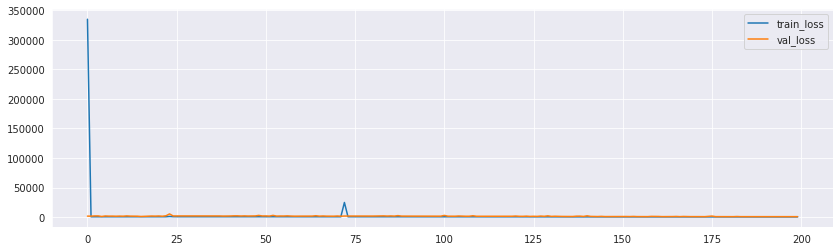

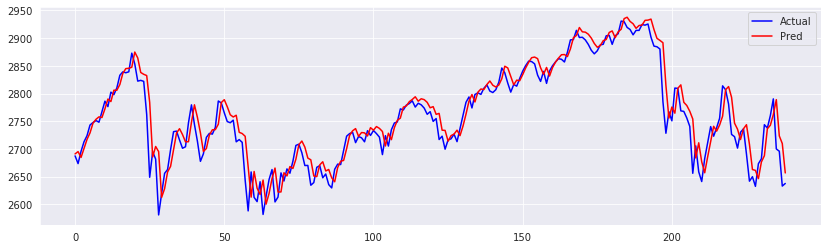

In [12]:
plt.figure(figsize=(14, 4))
plt.plot(history_vanilla.history['loss'], label='train_loss')
plt.plot(history_vanilla.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(y_test, color='b', label='Actual')
plt.plot(yhat, color='r', label='Pred')
plt.legend(loc='best')
plt.show()

## 2. Stacked LSTM

In [13]:
# define model
model_stacked = Sequential()
model_stacked.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model_stacked.add(LSTM(50, activation='relu'))
model_stacked.add(Dense(1))
model_stacked.compile(optimizer='adam', loss='mse')
print(model_stacked.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 7, 50)             10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
# fit model
history_stacked = model_stacked.fit(X_train,
                                    y_train,
                                    epochs=200,
                                    verbose=0,
                                    validation_data=(X_val, y_val))

In [15]:
# demonstrate prediction
yhat = model_stacked.predict(X_test, verbose=0)
r2 = round(r2_score(y_test, yhat), 3)
mape = round(mean_absolute_percentage_error(y_test, yhat), 3)
model_stacked.save(lstm_models_folder + 'stacked_lstm-' + f'r2({r2})-mape({mape}).h5')
print(f'r2: {r2} Mape: {mape}')

r2: 0.852 Mape: 3.404


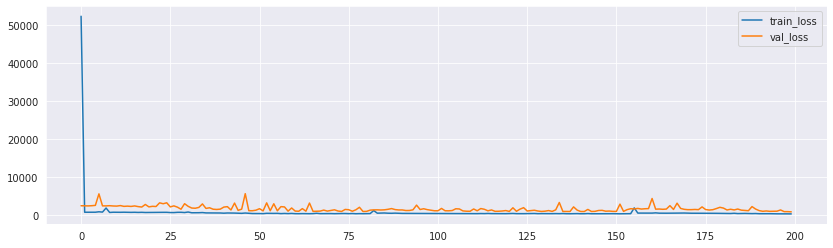

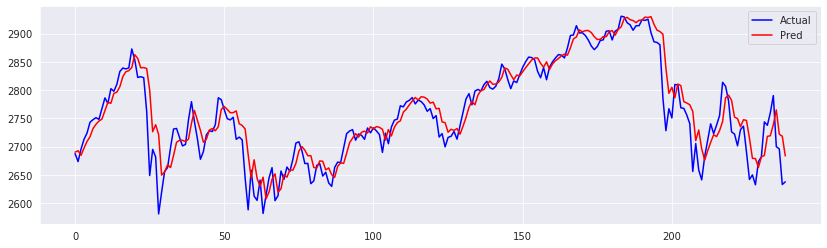

In [16]:
plt.figure(figsize=(14, 4))
plt.plot(history_stacked.history['loss'], label='train_loss')
plt.plot(history_stacked.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(y_test, color='b', label='Actual')
plt.plot(yhat, color='r', label='Pred')
plt.legend(loc='best')
plt.show()

## 3. Bidirectional LSTM

In [17]:
# define model
model_bidirectional = Sequential()
model_bidirectional.add(
    Bidirectional(LSTM(50, activation='relu'),
                  input_shape=(n_steps, n_features)))
model_bidirectional.add(Dense(1))
model_bidirectional.compile(optimizer='adam', loss='mse')
print(model_bidirectional.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 100)               20800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
# fit model
history_bidirectional = model_bidirectional.fit(X_train,
                                                y_train,
                                                epochs=200,
                                                verbose=0,
                                                validation_data=(X_val, y_val))

In [19]:
# demonstrate prediction
yhat = model_bidirectional.predict(X_test, verbose=0)
r2 = round(r2_score(y_test, yhat), 3)
mape = round(mean_absolute_percentage_error(y_test, yhat), 3)
model_bidirectional.save(lstm_models_folder + 'bidirectional_lstm-' + f'r2({r2})-mape({mape}).h5')
print(f'r2: {r2} Mape: {mape}')

r2: 0.876 Mape: 3.466


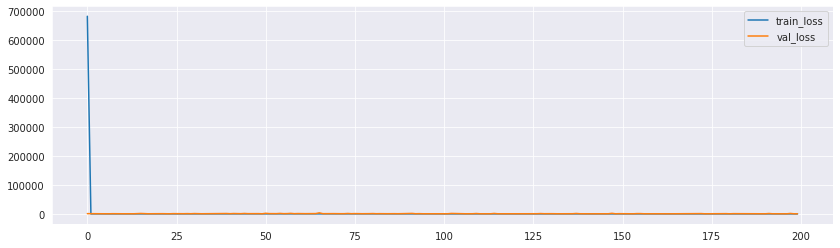

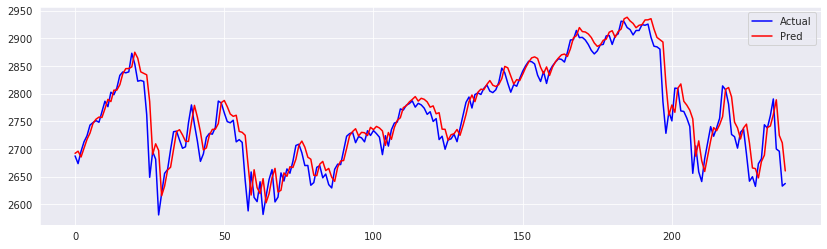

In [20]:
plt.figure(figsize=(14, 4))
plt.plot(history_bidirectional.history['loss'], label='train_loss')
plt.plot(history_bidirectional.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(y_test, color='b', label='Actual')
plt.plot(yhat, color='r', label='Pred')
plt.legend(loc='best')
plt.show()

In [23]:
def get_input_sequesnce(raw_seq):
    # define input sequence
    X, y = list(), list()
    n_steps = 10
    for i in range(len(raw_seq)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(raw_seq) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = raw_seq[i:end_ix], raw_seq[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)


def predict_prices(model, ref_data, days):
    model = load_model(model)
    df_pred = pd.read_csv(ref_data, index_col=[0], parse_dates=True)
    predictions = list()
    
    for i in range(days):
        input_values = df_pred.values[-11:]
        X, y = get_input_sequesnce(input_values)
        X = X.reshape((X.shape[0], X.shape[1], 1))
        df_pred = df_pred.append([{'Close':model.predict(X)[0, 0]}], ignore_index=True)
        predictions.append(model.predict(X)[0, 0])
        
    print(predictions)
    pred = {'Close_predictions': predictions}
    t = pd.to_datetime(df_pred.index[-1])
    indexes = pd.date_range(str(t.year) + '-' + str(t.month) + '-' + str(t.day), periods=days)
    pred = pd.DataFrame(pred, index=indexes)
    pred.to_csv('Predictions.csv')

In [24]:
predict_prices(model='LSTM_models/vanilla_lstm-r2(0.85)-mape(0.87).h5',
               ref_data='SP500_Sheet.csv',
               days=10)

[3122.247, 3117.9543, 3120.6177, 3119.8535, 3123.688, 3123.265, 3125.1497, 3125.7903, 3127.5327, 3128.3765]
